In [181]:
import numpy as np
import keras
import matplotlib.pyplot as plt
from scipy.special import logsumexp
np.random.seed(0)

We can use a bernoulli variable to create a mixture model that clusters image data. First we binarize the images.

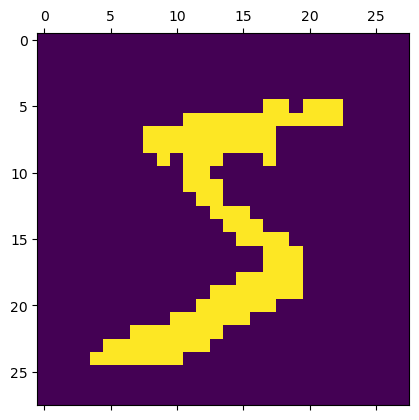

In [491]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)
x_bin = x_train.astype(np.float32)
x_bin /= 255.
x_bin = np.where(x_bin >= 0.5, 1, 0)
plt.matshow(x_bin[0])
N = 60000
x_bin = x_bin[:N]
x_bin = x_bin.reshape(N,-1)
D = x_bin.shape[1]
K = 20

 The assumption is that we have $D$ bernoulli variables $x$ with probabilites of success $\mu$ then the distribution is given by
$$p(x|\mu) = \prod_{i=1}^D \mu_i^{x_i} (1-\mu_i)^{1-x_i}$$.
In the finite mixture version for we now consider $K$ different $\mu$'s each of dimension $D$ and $K$ $\pi$'s giving the mixing coeffecients. Then the new probability is
$$ p(x|\mu_k) = \prod_{i=1}^D \mu_{ki}^{x_i} (1-\mu_{ki})^{1-x_i}$$
$$p(x|\mu,\pi) = \sum_{k=1}^K \pi_k p(x|\mu_k)$$
This leads to the following log likelihood
$$\sum_{n=1}^N \log \sum_{k=1}^K \pi_kp(x_n|\mu_k)$$

In the case of the multidimensional bernoulli there is some bad numerical behavior in practice. This is because of the products in $p(x|\mu)$ which give very small numbers, when we take the log these will blast off to $-\infty$. To deal with this we use the ["log-sum-exp" trick](https://gregorygundersen.com/blog/2020/02/09/log-sum-exp/) . In order to apply this we first need to compute the log probability instead, the bernoulli function below does this.

In [495]:
def bernoulli(xs,mus,pis):
    # xs : N x D
    # mus: K x D
    N,D,K = xs.shape[0],xs.shape[1],mus.shape[0]
    ll = xs@(np.log(mus).T)+ (1-xs)@(np.log(1-mus).T)
    return np.log(pis) + ll - logsumexp(ll+np.log(pis), axis=1, keepdims=True)

In [497]:
#bernoulli_prob(x_bin,np.array([[.1]*D]*3),np.array([.1]*3))

In [527]:

def log_likelihood(xs,mus,pis):
    # x: N x D
    # mus: K x D
    # sigmas K x D x D
    # pis K x 1
    log_probs = bernoulli_prob(xs,mus,pis)
    return np.sum(np.exp(log_probs - logsumexp(log_probs, axis=1,keepdims=True)))

In [529]:
log_likelihood(x_bin,np.array([[1/D]*D]*K),np.array([1/K]*K))

59999.99999999986

Next we introduct the latent variables $z_n$ which tell us the actual cluster $x_n$ belongs to. The conditonal distribution is
$$p(x|z,\mu) = \prod_{k=1}^k p(x|\mu_k)^{z_k}$$
so the probability is simply the probability under the $k$th cluster.
the prior is given by
$$p(z|\pi) = \prod_{k=1}^k \pi_k^{z_k}$$

From this the complete log likelihood can be computed, see (bishop 463 for details). The conceptual thing to note is that we always are computing the expectation of our latent variables and then trying to maximize $\mathbb{E}_z[\log(p(X,Z|\theta)]$

In this case the expected value is
$$\gamma(z_{nk}) = \mathbb{E}[z_{nk}] = \frac{\pi_k p(x_n|\mu_k)}{\sum_{j=1}^{K} \pi_j p(x_n|\mu_j)}$$
which we compute in the $E$ step and in the $M$ step we update according to 
$$N_k = \sum_{n=1}^N \gamma(z_{nk})$$
$$\mu_k = \frac{1}{N_k} \sum_{n=1}^N \gamma(z_{nk})x_n$$
$$\pi_k = \frac{N_k}{N}$$

In [531]:
def em_algo(xs,mus,pis,tol=1e-6,max_iters=500):
    N,D,K = xs.shape[0],xs.shape[1],mus.shape[0]
    def get_es(m,p):
        x = p*bernoulli_prob(xs,m,p)
        d = logsumexp(x,axis=1).reshape(N,1)
        return x/d
        
    def maximize_step(es):
        #N_k sum kth column
        Nk = np.sum(es,axis=0).reshape(K,1)
        pis_new = Nk/N
        mus_new = np.sum(es.reshape(N,K,1)*xs.reshape(N,1,D),axis=0)
        mus_new /= Nk
        return mus_new,pis_new.reshape(1,K)
    eps = 1e-6
    old_mus,old_pis = mus,pis
    from tqdm import tqdm
    for i in tqdm(range(max_iters)):
        condprobs = np.exp(bernoulli(xs,old_mus,old_pis))
        gammas = condprobs/condprobs.sum(axis=1,keepdims=True)
        Nk = gammas.sum(axis=0,keepdims=True)
        
        next_mus = (xs.T@gammas)+eps
        next_mus /= Nk+ D*eps
        next_pis = (Nk+eps)/(N + D*eps)
        if np.allclose(old_mus,next_mus.T) or np.allclose(old_pis,next_pis):
            print(f"Converged early on iter {i+1}")
            break
        old_mus,old_pis = next_mus.T,next_pis
    return old_mus,old_pis  
    

def guess_params(xs,k,d):
    N = xs.shape[0]
    pis = np.array([1/k]*k)
    mus = np.random.uniform(low=.25,high=.75,size=(k,d))
    mus /= mus.sum(axis=1)[:,None]
    return mus,pis


guess_mu, guess_pi = guess_params(x_bin,K,D)
approx_mus,approx_pis = em_algo(x_bin,guess_mu,guess_pi)

 35%|███▍      | 174/500 [01:40<03:08,  1.73it/s]

Converged early on iter 175


Even with the extra clusters added (notice $K = 20$!) we still fail to learn all of the digits

(20, 784)


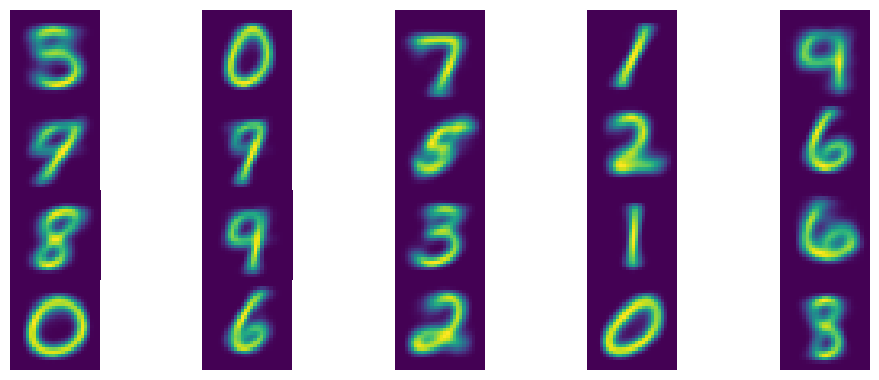

In [533]:
print(approx_mus.shape)
fig,ax = plt.subplots(4,5)
fig.subplots_adjust(bottom=0.4, top=0.7, hspace=0)
idx = 0
for i in range(4):
    for j in range(5):
        fig.set_size_inches(12,12)
        ax[i,j].axis('off')
        ax[i,j].matshow(approx_mus[idx].reshape(28,28))
        idx += 1

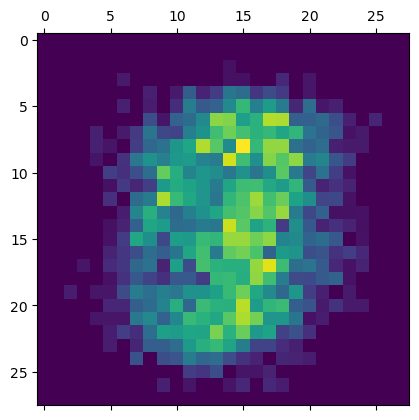

In [559]:
def sample():
    z = np.random.binomial(1, approx_mus).T@approx_pis.T
    return z

# can sample from the distribution pretty bad though
z = sample()
plt.matshow(z.reshape(28,28))